In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader.data import DataReader
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop

In [260]:
# Stock market data loading from yahoo and setting data
#####################
plt.style.use("fivethirtyeight")
FIG_SIZE=(14, 7)

TEST_TRAIN_SPLIT = 0.9
TIME_STEPS = 50
#####################

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day) 
df = DataReader('MSFT', 'yahoo', start, end)
df['Daily Change'] = df['Adj Close'].pct_change()
df['Daily Change'][0] = 0

scaler = MinMaxScaler(feature_range=(0,1))
tec_ind = df[['Daily Change']].values
tec_ind = scaler.fit_transform(tec_ind)
zero_change_val = tec_ind[0][0]

split_val = int(len(data)*TEST_TRAIN_SPLIT)
X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(0,split_val-TIME_STEPS):
    X_train.append(data[i : i+TIME_STEPS, 0])
    Y_train.append(data[i+TIME_STEPS, 0])
for i in range(split_val-TIME_STEPS,len(data)-TIME_STEPS):
    X_test.append(data[i : i+TIME_STEPS, 0])
    Y_test.append(data[i+TIME_STEPS, 0])

X_train, Y_train, X_test, Y_test = np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))
Y_test  = np.reshape(Y_test, (Y_test.shape[0], 1))

train = scaler.inverse_transform(data[:split_val])
valid = scaler.inverse_transform(data[split_val:])
Y_test = scaler.inverse_transform(Y_test)

In [261]:
# LSTM modeling

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, batch_size=1, epochs=5)

Epoch 1/5
629/629 [==============================] - 13s 20ms/step - loss: 0.0128
Epoch 2/5
629/629 [==============================] - 13s 20ms/step - loss: 0.0090
Epoch 3/5
629/629 [==============================] - 12s 20ms/step - loss: 0.0085
Epoch 4/5
629/629 [==============================] - 12s 20ms/step - loss: 0.0080
Epoch 5/5
629/629 [==============================] - 12s 20ms/step - loss: 0.0081


In [262]:
# Calculating model efficency
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

profit_fac = 1
for i in range(len(X_test)):
    if (predictions[i][0]> 0):
        profit_fac*= (1 + Y_test[i][0])

profit_fac

1.5834620100430516

When prediction is above 0 model thinks return is positive for that days and we should buy on start of the day and sell at the end. When under 0 we should skip that day.

In [263]:
# Calculating accuracy
accuracy = 0
for i in range(len(X_test)):
    if ((predictions[i][0]> 0 and Y_test[i][0]>0) or (predictions[i][0]< 0 and Y_test[i][0]<0)):
        accuracy+=1

accuracy/len(X_test)

0.618421052631579

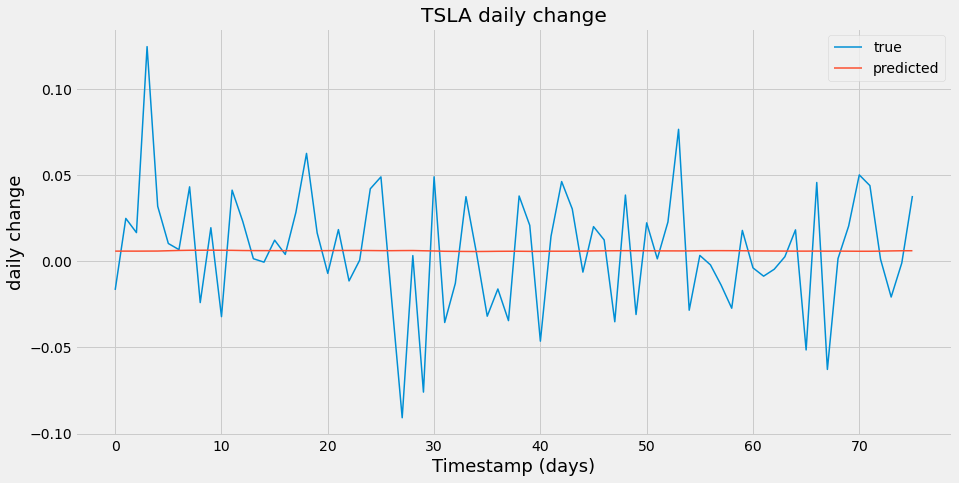

In [264]:
# Plot the data
plt.figure(figsize=FIG_SIZE)
plt.plot(valid, linewidth=1.5)
plt.plot(predictions, linewidth=1.5)
plt.title('TSLA daily change')
plt.xlabel('Timestamp (days)', fontsize=18)
plt.ylabel('daily change', fontsize=18)
plt.legend(['true','predicted'], loc="upper right")
# plt.gca().set_xlim([250,300])
plt.show()